1. Lectura del archivo parquet

In [1]:
import pandas as pd

# Ruta del archivo parquet
ruta = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\datos_yelp_completo.parquet"

# Leer el parquet
df_yelp = pd.read_parquet(ruta, engine="pyarrow")


ArrowMemoryError: realloc of size 402653184 failed

2. Normalización de las variables

In [2]:
#Se normalizan las variables de los usuarios de Yelp- Esta es la metodologia mas adecuado dada un EDA de estas variables-
import numpy as np

df_yelp['useful_x_escalado'] = np.log1p(df_yelp['useful_x'])
df_yelp['funny_x_escalado'] = np.log1p(df_yelp['funny_x'])
df_yelp['cool_x_escalado'] = np.log1p(df_yelp["cool_x"])
df_yelp['review_count_x_escalado'] = np.log1p(df_yelp["review_count_x"])
df_yelp['useful_y_escalado'] = np.log1p(df_yelp["useful_y"])
df_yelp['funny_y_escalado'] = np.log1p(df_yelp['funny_y'])
df_yelp['cool_y_escalado'] = np.log1p(df_yelp['cool_y'])
df_yelp['fans_escalado'] = np.log1p(df_yelp['fans'])
df_yelp['compliment_hot_escalado'] = np.log1p(df_yelp['compliment_hot'])
df_yelp['compliment_more_escalado'] = np.log1p(df_yelp['compliment_more'])
df_yelp['compliment_profile_escalado'] = np.log1p(df_yelp['compliment_profile'])
df_yelp['compliment_cute_escalado'] = np.log1p(df_yelp['compliment_cute'])
df_yelp['compliment_list_escalado'] = np.log1p(df_yelp['compliment_list'])
df_yelp['compliment_note_escalado'] = np.log1p(df_yelp['compliment_note'])
df_yelp['compliment_plain_escalado'] = np.log1p(df_yelp["compliment_plain"])
df_yelp['compliment_cool_escalado'] = np.log1p(df_yelp['compliment_cool'])
df_yelp['compliment_funny_escalado'] = np.log1p(df_yelp['compliment_funny'])
df_yelp['compliment_writer_escalado'] = np.log1p(df_yelp['compliment_writer'])
df_yelp['compliment_photos_escalado'] = np.log1p(df_yelp['compliment_photos'])
df_yelp['review_count_y_escalado'] = np.log1p(df_yelp['review_count_y'])
# Falta verificar si falta otra variable por realizar tratamiento


In [3]:
#Borramos las columnas que no están escaladas
df_yelp.drop(columns=["useful_x","funny_x","cool_x","review_count_x","useful_y",
                      "funny_y","cool_y",'fans','compliment_hot','compliment_more','compliment_profile',
                      'compliment_cute','compliment_list','compliment_note',"compliment_plain",'compliment_cool',
                      'compliment_funny','compliment_writer','compliment_photos','review_count_y',"friends"],
             
             
             inplace=True)

3. Creamos la columna de sentimiento

In [4]:
#Limpieza y tokenizado 
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Todas las variables que tengan texto las procesamos- solo la reseña
columnas_a_normalizar = ["text"]

#Normalizar- en ingles dado que el texto es en ingles.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Funcion para reprocesar el texto
def preprocess_text(text):
    # Minusculas
    text = text.lower()
    
    # Quitar puntuación
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenizar (mejor con nltk)
    tokens = word_tokenize(text)
    
    # Quitar stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Reconstruir el texto
    return ' '.join(tokens)


# Aplicar funcion a las columnas que tienen texto
for column in columnas_a_normalizar:
    df_yelp.loc[:, column] = df_yelp[column].apply(
    lambda x: preprocess_text(x) if pd.notnull(x) else x
)

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

#Borrar filas con vacios
df_yelp = df_yelp.dropna(subset=["text"])

#Resetear indice
df_yelp = df_yelp.reset_index(drop=True)

# Para la variable Google- text
limpios_text=df_yelp["text"]
#Instanciamos
vectorizer = CountVectorizer()
# Initializar Vader
analyzer = SentimentIntensityAnalyzer()
X = vectorizer.fit_transform(limpios_text)

#Creamos la funcion vader de sentimiento y obtenemos la variable sentimiento de Vader Compund- toca sacar dos
def vader_sentiment(text):
    # Obtener Vader scores
    scores = analyzer.polarity_scores(text)

    # Clasificar Vader
    if scores['compound'] >= 0.05:
        sentiment = "Positive"
    elif scores['compound'] <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    # Devolver clasificación
    return {
        "vader_neg_google": scores["neg"],
        "vader_neu_google": scores["neu"],
        "vader_pos_google": scores["pos"],
        "vader_compound_google": scores["compound"],
        "vader_sentiment_google": sentiment
    }


# Aplicar Vader 
df_yelp_review= df_yelp.join(
   df_yelp["text"].apply(lambda x: pd.Series(vader_sentiment(x)))
)

4. Creamos la variable "influencer" para explicar los sentimientos.

In [7]:
# Calcular el percentil 75 (es decir, el valor que separa el 25% superior)
percentil_75 =df_yelp_review['fans_escalado'].quantile(0.75)

# Filtrar los valores que están en el 25% más alto
influencers= df_yelp_review[df_yelp_review['fans_escalado'] >= percentil_75].copy()

In [8]:
from sklearn.preprocessing import StandardScaler
#Creamos clustering de los influencers

influencers["num_años"] = influencers["elite"].apply(
    lambda x: len(str(x).split(",")) if pd.notnull(x) else 0)


columnas_clustering = ['fans_escalado', 'useful_x_escalado','funny_x_escalado', 
                       'cool_x_escalado','cool_y_escalado', 'review_count_x_escalado','useful_y_escalado','funny_y_escalado',
                       'compliment_hot_escalado','compliment_more_escalado', 'compliment_profile_escalado',
                       'compliment_cute_escalado', 'compliment_list_escalado',
                        'compliment_note_escalado', 'compliment_plain_escalado',
                        'compliment_cool_escalado', 'compliment_funny_escalado',
                        'compliment_writer_escalado','compliment_photos_escalado',"num_años" ] 

influencers = influencers.fillna(0)


X = influencers[columnas_clustering]
#Rellenamos nulos con 0... toca probar con media si tiene sentido
X = X.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

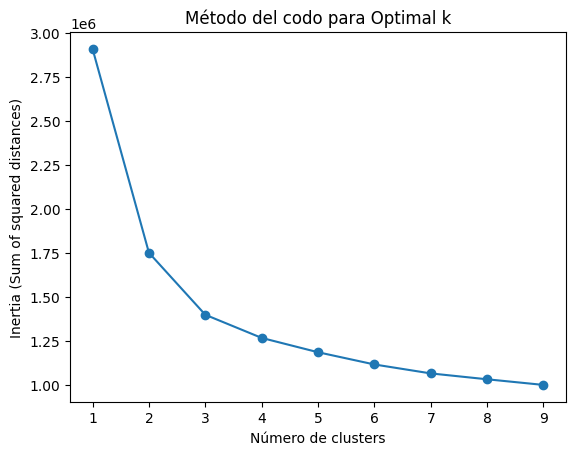

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Metodo codo para encontrar optimo K
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

#Se crea grafica
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Método del codo para Optimal k')
plt.show()


In [11]:
# X es un dataframe
X_scaled_array = scaler.fit_transform(X)  

# Convertir a DataFrame con índices y columnas originales
X_scaled = pd.DataFrame(X_scaled_array, index=X.index, columns=X.columns)

# Ahora alinear influencers con X_scaled
influencers = influencers.loc[X_scaled.index]

# Entrena KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Añade clusters
influencers['cluster'] = clusters

# Selecciona solo columnas numéricas + cluster
num_cols = influencers.select_dtypes(include='number').columns.tolist()
if 'cluster' not in num_cols:
    num_cols.append('cluster')

#Mostrar la tabla completa

pd.set_option('display.max_rows', None)   # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', None)    # No corta líneas
pd.set_option('display.max_colwidth', None) # No corta texto de celdas

# Agrupa y saca medias
print(influencers[num_cols].groupby('cluster').mean())


c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


          stars_x   stars_y   is_open  MedianHH_Income  Median_Home_Value  \
cluster                                                                     
0        3.804455  3.766277  0.728210     85043.643444      220723.544076   
1        3.863304  3.768504  0.743962     85296.049957      223204.322359   
2        3.831793  3.803111  0.739702     84817.377912      219928.670884   

         Median_RE_Taxes  average_stars  useful_x_escalado  funny_x_escalado  \
cluster                                                                        
0            6861.106912       3.833879           1.074582          0.473891   
1            6867.465727       3.857756           1.665726          1.051288   
2            6857.850389       3.828379           0.661387          0.201513   

         cool_x_escalado  review_count_x_escalado  useful_y_escalado  \
cluster                                                                
0               0.732079                 5.527199           7.141696 

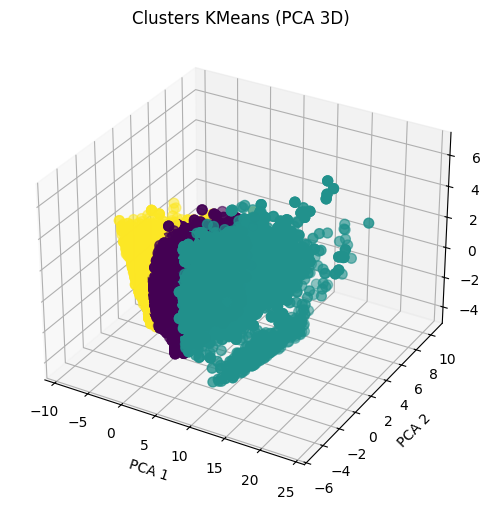

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=clusters, cmap='viridis', s=50)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('Clusters KMeans (PCA 3D)')
plt.show()

In [13]:
# 1. Crear un diccionario de mapeo
cluster_map = {
    1: "top_influencer",   # cluster 1 = los más influyentes
    0: "intermedio",       # cluster 0 = nivel medio
    2: "micro_influencer"  # cluster 2 = novatos/micro
}

# 2. Reemplazar en el DataFrame
influencers["cluster_label"] = influencers["cluster"].map(cluster_map)

# 3. Crear dummies con nombres
cluster_dummies = pd.get_dummies(influencers["cluster_label"])

# 4. Unir al DataFrame original
influencers = pd.concat([influencers, cluster_dummies], axis=1)

# 5. Ver un ejemplo
print(influencers[["cluster", "cluster_label", "top_influencer", "intermedio", "micro_influencer"]].head())


    cluster     cluster_label  top_influencer  intermedio  micro_influencer
6         0        intermedio           False        True             False
7         0        intermedio           False        True             False
8         0        intermedio           False        True             False
9         2  micro_influencer           False       False              True
10        2  micro_influencer           False       False              True


In [14]:
# 1) Quedarnos con una fila por user_id en influencers y preparar lookup
cols_inf = ["user_id", "top_influencer", "intermedio", "micro_influencer"]
inf_unique = (
    influencers[cols_inf]
    .groupby("user_id")[["top_influencer","intermedio","micro_influencer"]]
    .max()  # si hay duplicados por user_id, toma 1 si existe
    .astype(int)
)

lookup = inf_unique.to_dict(orient="index")  # user_id -> {top_influencer:0/1, ...}

# 2) Inicializar dummies en df_yelp_review (por defecto micro=1)
df_yelp_review["top_influencer"] = 0
df_yelp_review["intermedio"] = 0
df_yelp_review["micro_influencer"] = 1

# 3) Recorrer fila por fila y sobrescribir si el user_id está en influencers
for i, uid in df_yelp_review["user_id"].items():
    vals = lookup.get(uid)
    if vals is not None:
        df_yelp_review.at[i, "top_influencer"] = vals.get("top_influencer", 0)
        df_yelp_review.at[i, "intermedio"] = vals.get("intermedio", 0)
        df_yelp_review.at[i, "micro_influencer"] = vals.get("micro_influencer", 0)

# (Opcional) asegurar tipo int 0/1
df_yelp_review[["top_influencer","intermedio","micro_influencer"]] = (
    df_yelp_review[["top_influencer","intermedio","micro_influencer"]].astype(int)
)



4. Particionamos los datos

In [16]:
#Particion Yelp
df_fast_food=df_yelp_review[ df_yelp_review['category']=="FastFood"].copy()
df_pizza_pasta=df_yelp_review[ df_yelp_review['category']=="PizzaandPasta"].copy()
df_asiatica=df_yelp_review[ df_yelp_review['category']=="AsianCuisine"].copy()
df_healthy=df_yelp_review[ df_yelp_review['category']=="Healthy&SpecialtyDiets"].copy()
df_latin=df_yelp_review[ df_yelp_review['category']=="Latin&Mexican"].copy()

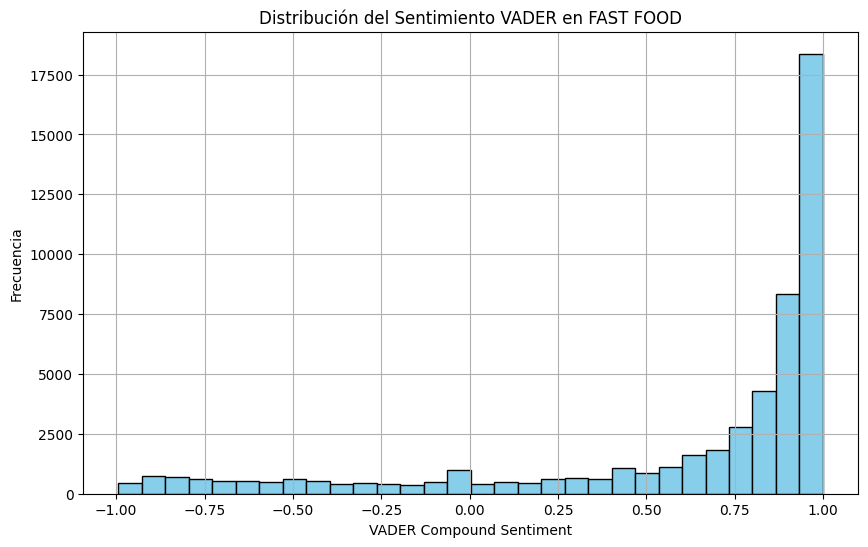

In [17]:
#Distribucion de los sentimientos en FAST FOOD
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_fast_food['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en FAST FOOD')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [18]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_fast_food.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)


       County  Average_VADER_Sentiment
7       SALEM                 0.223109
4  GLOUCESTER                 0.442354
3  CUMBERLAND                 0.472007
6      MERCER                 0.517475
1  BURLINGTON                 0.543282
0    ATLANTIC                 0.642514
2      CAMDEN                 0.648212
5   HUNTERDON                 0.762319


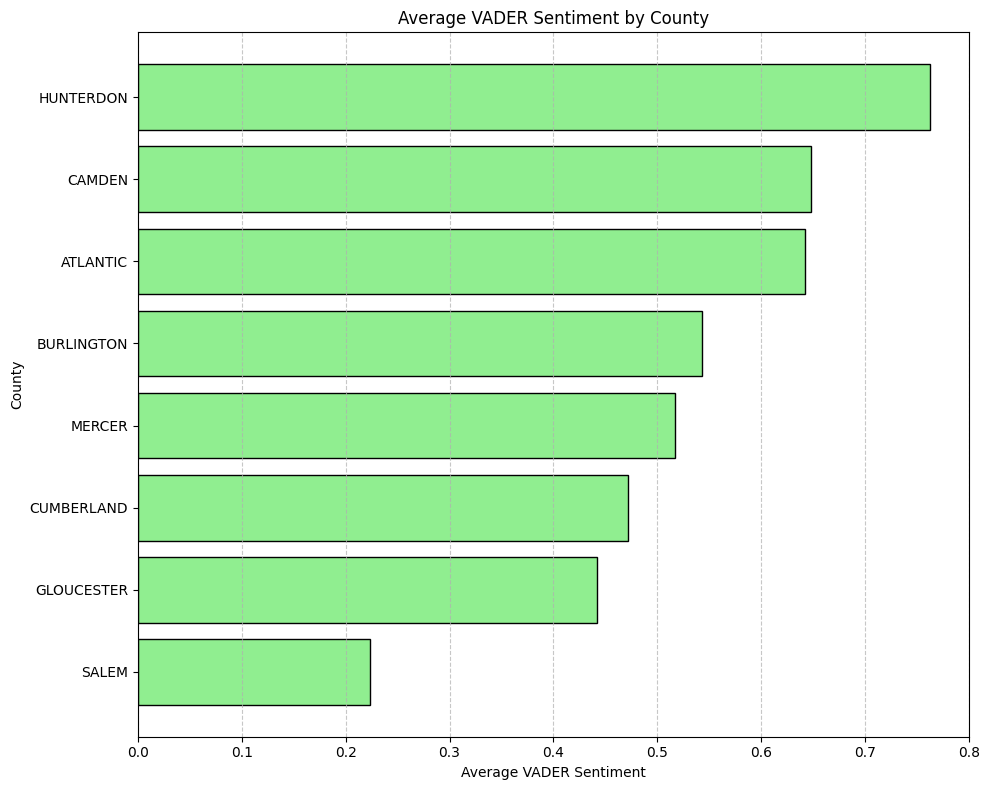

In [19]:
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(10, 8))

# Gráfico de barras horizontal
plt.barh(
    promedios_sentimiento['County'],
    promedios_sentimiento['Average_VADER_Sentiment'],
    color='lightgreen',
    edgecolor='black'
)

# Títulos y etiquetas
plt.xlabel('Average VADER Sentiment')
plt.ylabel('County')
plt.title('Average VADER Sentiment by County')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [23]:
conteo_county = df_fast_food['County'].value_counts().reset_index()
conteo_county.columns = ['County', 'Count']
print(conteo_county)


       County  Count
0      CAMDEN  36015
1  BURLINGTON   9525
2  GLOUCESTER   4138
3      MERCER   1476
4       SALEM    394
5   HUNTERDON    314
6  CUMBERLAND     15
7    ATLANTIC      7


Al igual que en Google, SALEM aparece en el último lugar del sentimiento y por gran diferencia a pesar de tener mas reseñas que otros counties.

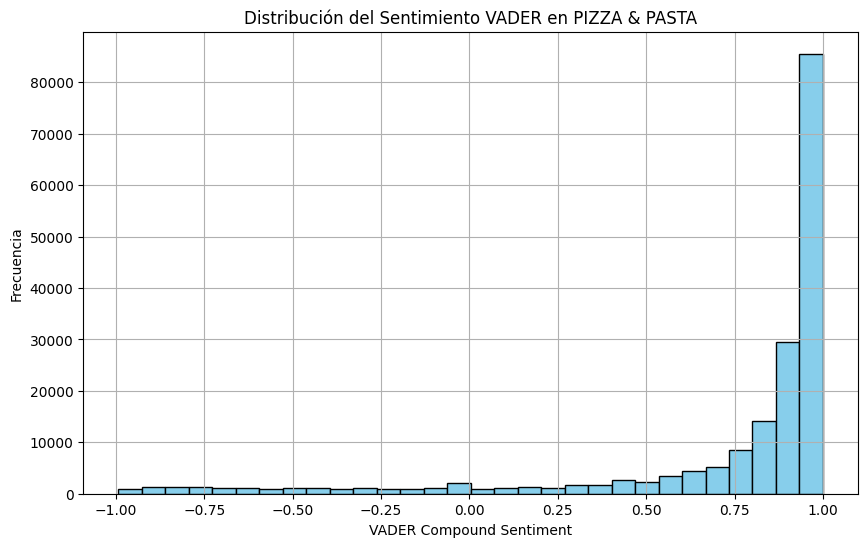

In [20]:
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_pizza_pasta['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en PIZZA & PASTA')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [21]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_pizza_pasta.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)

       County  Average_VADER_Sentiment
0    ATLANTIC                 0.061791
3  CUMBERLAND                 0.610282
7       SALEM                 0.661728
4  GLOUCESTER                 0.664408
1  BURLINGTON                 0.673778
5   HUNTERDON                 0.702861
6      MERCER                 0.742307
2      CAMDEN                 0.749314


In [ ]:
conteo_county = df_pizza_pasta['County'].value_counts().reset_index()
conteo_county.columns = ['County', 'Count']
print(conteo_county)


       County   Count
0      CAMDEN  130954
1  BURLINGTON   22851
2  GLOUCESTER   13469
3      MERCER    9652
4   HUNTERDON    1872
5       SALEM    1801
6  CUMBERLAND     119
7    ATLANTIC      11


Dado que las reseñas son muy pocas en Atlantic, estas no pueden ser representativas para determinar que hay un problema en ese county.

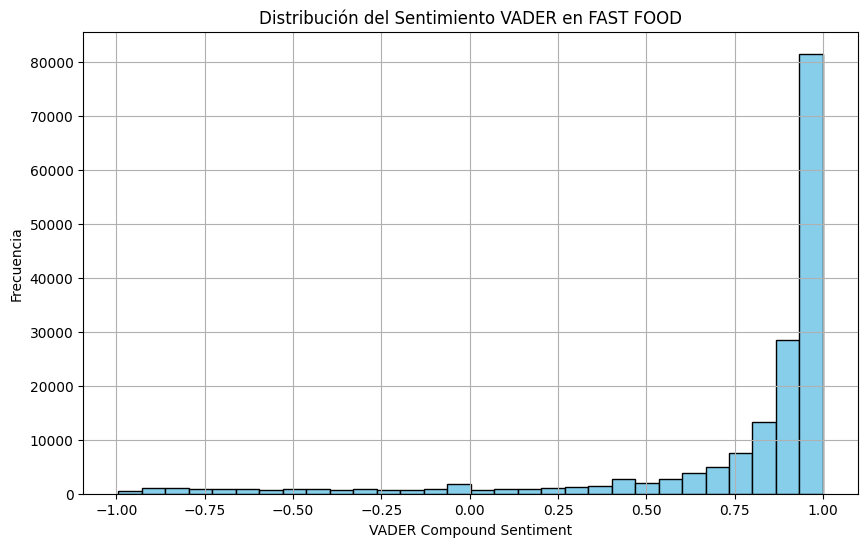

In [24]:
#Distribucion de los sentimientos en ASIATICA
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_asiatica['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en FAST FOOD')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [25]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_asiatica.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)

       County  Average_VADER_Sentiment
6       SALEM                 0.596479
0    ATLANTIC                 0.626150
5      MERCER                 0.692354
3  GLOUCESTER                 0.696752
4   HUNTERDON                 0.701027
1  BURLINGTON                 0.731635
2      CAMDEN                 0.770984


Salem sigue siendo la mas baja pero sin tanta diferencia en la categoría asiática. También es importante anotar que en CAMDEN las reseñas tienen el promedio más alto de reseñas y además tienen muchas mas reseñas que cualquier otro county. En conclusión, se nota que existe un cluster importante en esta parte de restaurantes que son de buena calidad.

In [26]:
conteo_county = df_asiatica['County'].value_counts().reset_index()
conteo_county.columns = ['County', 'Count']
print(conteo_county)


       County   Count
0      CAMDEN  137448
1  BURLINGTON   19297
2  GLOUCESTER    6741
3      MERCER    2073
4   HUNTERDON     472
5       SALEM     328
6    ATLANTIC      50


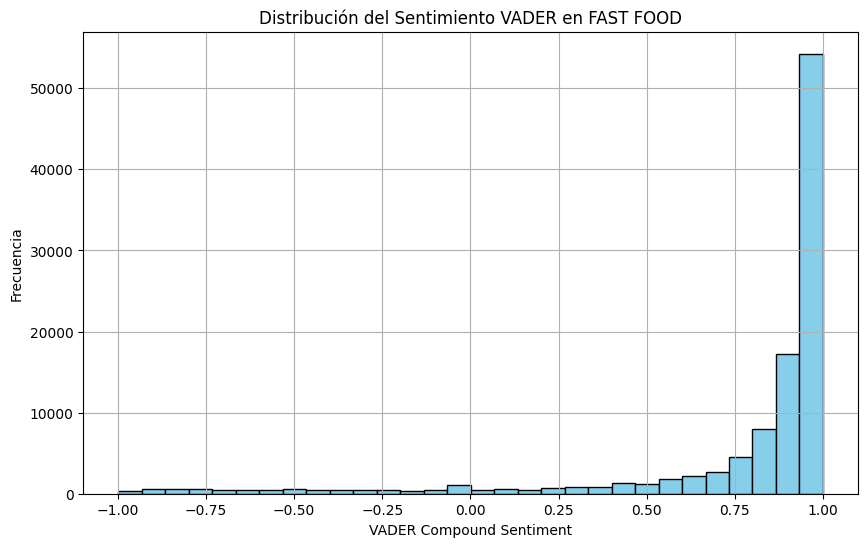

In [27]:
#Distribucion de los sentimientos en HEALTHY
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_healthy['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en FAST FOOD')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [28]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_healthy.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)

       County  Average_VADER_Sentiment
2  CUMBERLAND                 0.571024
6       SALEM                 0.691635
3  GLOUCESTER                 0.710760
0  BURLINGTON                 0.723350
5      MERCER                 0.780550
4   HUNTERDON                 0.785738
1      CAMDEN                 0.787782


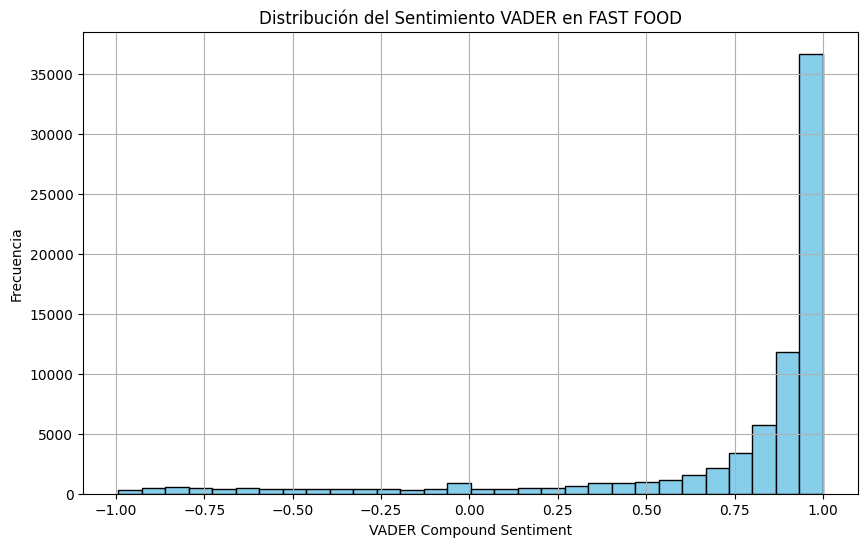

In [29]:
#Distribucion de los sentimientos en HEALTHY
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_latin['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en FAST FOOD')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [30]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_latin.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)

       County  Average_VADER_Sentiment
2  GLOUCESTER                 0.606675
0  BURLINGTON                 0.661913
5       SALEM                 0.722033
4      MERCER                 0.752959
3   HUNTERDON                 0.756642
1      CAMDEN                 0.764863


**** Conclusión:

1. Al igual que los datos de Google, SALEM tiene un problema con la categoría Fast Food. Es baja y es donde concentraremos nuestro esfuerzo para entender como mejorar la calidad para entrar y tomar mercado sin tanta competencia.

In [31]:
import os

# Define the folder path
output_folder = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET"

# Save two DataFrames as CSV
df_fast_food.to_csv(os.path.join(output_folder, "df_fast_food_yelp.csv"), index=False, encoding="utf-8-sig")
